## Python-Data Science-Workshop: Build a Simple Chatbot

### X. Idea: 
Creating a (simple) chatbot called 'Chatty' by building a decision tree model, which gets trained on sentence patterns of different categories (tags: greetings, joke, help etc.). After training, it shall process a user input by predicting its category and provide a random answer of the same category. Since words are not an easy input to train and test a classification model, the sentences of the training data and the user input are converted into bag-of-words (bow).

- Snap of the training data: tag, patterns, responses

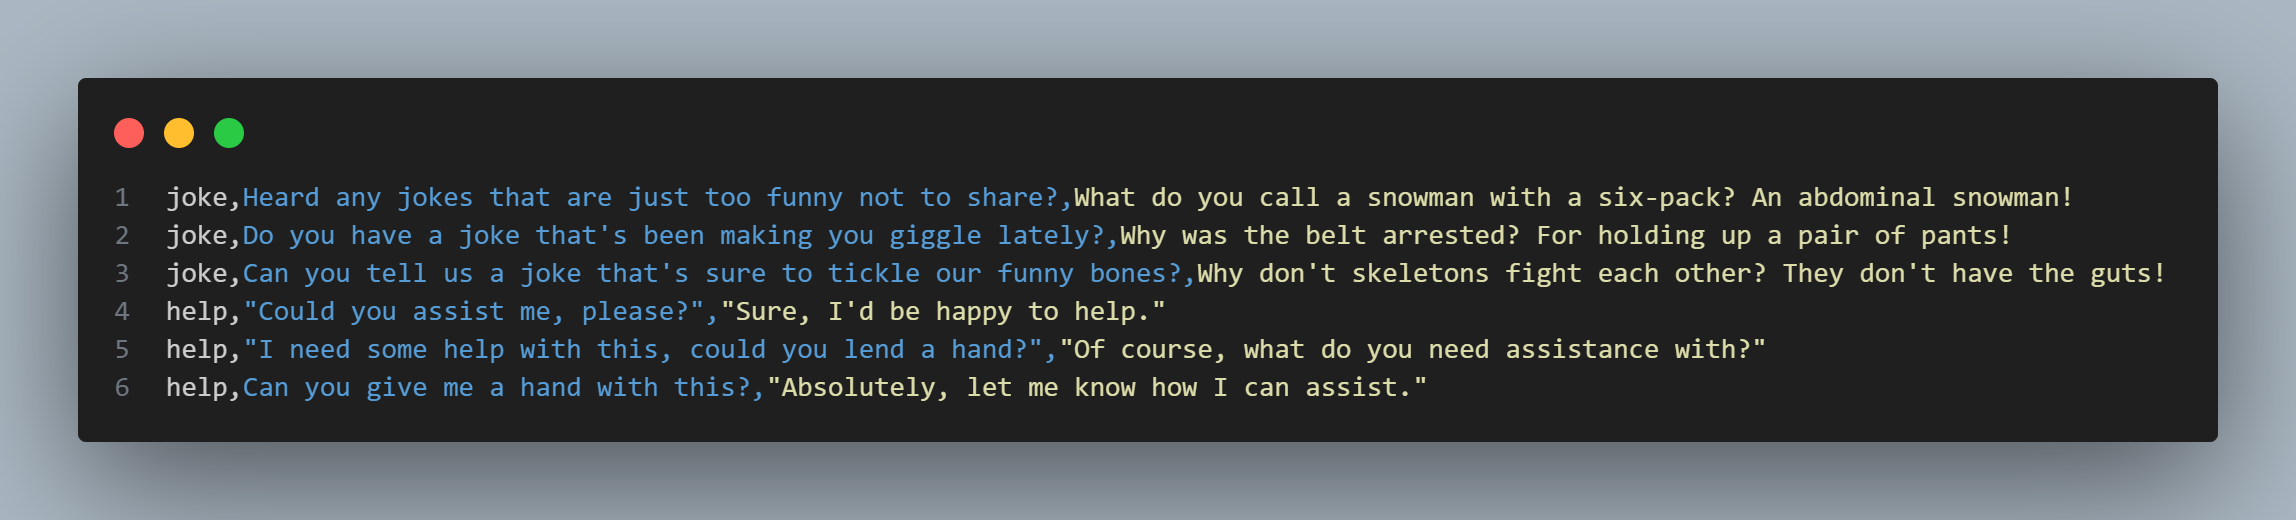

- Credits: Training dataset "ChatbotTraining.csv" from https://github.com/cornelius31415/ARTIFICIAL-INTELLIGENCE/tree/main/CHATBOT

Note: The dataset used for training is quite limited with 210 samples, 30 sentences of 7 categories (tags: greeting, goodbye, joke, help, thanks, name, purpose). Thus, the resulting model cannot provide elaborate or newly generated answers like we are used to from hugely trained LLMs, but will always choose a response from one of the provided categories. It cannot learn new words or themes as it bases its predictions solely on the words in the dataset patterns - the joke responses are still pretty funny.

Additionally, a GUI was added with tkinter to make the conversation with 'Chatty' more convenient. So let's chat! :) 

__________________________________________

### 1. Generating of Vocabulary and Bag of Words for Patterns in Dataset

- Sentences in the dataset all have different lenghts -> need to be in a comparable format = *bag of words*:
  - *Vocabulary*: list of unique words of input, e.g. ['a', 'able', 'about', 'accomplish', 'achieve', 'actions', ...]
  - *Bag of words* for the sentence "A player about to start actions." -> [1, 0, 1, 0, 0, 1, ......] (same length as vocabulary, 0/1 for occurence of word in sentence)
- *Tokenization*: each word (+ punctuation) is condsidered a token, punctations need to be excluded separately not to confuse the training
- Considerations about using the bag of words model: 
  - *Advantages*: easy to implement for beginners; bag of words provides different kind of information about a sentence than e.g. number of words or characters; creates a binary numeric dataset for training classification algorithms 
  - *Disadvantages*: the order of words, grammar and context gets lost; new words outside the vocabulary are not considered for neither training nor predictions.

Here, I describe the steps undergone to code the application:

1. Installing pandas, numpy, nltk and sklearn *libraries* for the data science/ machine learning part.
2. Downloading the training *dataset* "ChatbotTraining.csv" & importing it as pandas dataframe.
3. *Functions* to build a vocabulary from given sentences and to transform a sentence into a bag of words according to the vocabulary previously built.
4. Creating the *vocabulary* by adding all words (no punctuations) of each sentence of the dataset column "patterns" -> sorted list of unique words.
5. Converting each "pattern" sentence into a bag of words & save this list of lists as numpy array.

In [23]:
## 0. Import libraries for the whole notebook - RUN ME FIRST!
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize                 # Natural Language Toolkit library for language processing, recommended for precise tokenizing
# nltk.download('punkt')                                # only needed first time
import string                                           # string.punctuation contains all common punctuations -> used to exclude from bag of words

from sklearn.tree import DecisionTreeClassifier         # sklearn-Decision tree algorithm used for machine learning model
from sklearn.model_selection import train_test_split    # splitting only intermediate to test model and calculate accuracy
from sklearn.metrics import accuracy_score

from tkinter import Tk, Label, Button, Entry, END, WORD, RIGHT, Y  # for GUI application
from tkinter.scrolledtext import ScrolledText           # replaces separate Text + Scrollbar
import random                                           # for random choice of answers given by the chatbot

In [2]:
## 1.1 Data Import as pandas-Dataframe
df_original = pd.read_csv("ChatbotTraining.csv")        # Import Training data from https://github.com/cornelius31415/ARTIFICIAL-INTELLIGENCE/tree/main/CHATBOT
# print(df_original.head(10))                           # .to_string() for whole dataframe; df.info() to receive info on structure, null variables; 
                                                        # df.drop() to delete certain columns/rows

''' Data structure of "ChatbotTraining.csv": 
    - 3 columns: 'tag'/category (greeting, purpose, joke...), 'patterns' (example sentences), 'responses' (answers of Chatbot)
    - 210 rows in Data, no null values
'''

' Data structure of "ChatbotTraining.csv": \n    - 3 columns: \'tag\'/category (greeting, purpose, joke...), \'patterns\' (example sentences), \'responses\' (answers of Chatbot)\n    - 210 rows in Data, no null values\n'

In [ ]:
## 1.2 Functions vocabulary_fill() and bag_of_words()

vocabulary = []
def vocabulary_fill(vocabulary, sentence):
    ''' Function creates a vocabulary list filled with all unique words from input sentence, excluding punctuations '''
    tokens = word_tokenize(sentence.lower())            # separates sentence into tokens = words; .lower() ensures that uppercase letters are converted
    punctuations = list(string.punctuation)            # use string-library instead of defining a list like [',', '.', '!', '?']              
    tokens = [word for word in tokens if word not in punctuations]   # filters tokens and takes only those that are no punctuations
    vocabulary.extend(tokens)                           # adds tokens to vocabulary
    vocabulary = list(set(vocabulary))                  # removes duplicates by converting into set (collection with unique items) and back to list(); 
                                                        # list(set()) is more efficient than iteration over list with nested condition checking "if word not in vocabulary"
    return vocabulary

def bag_of_words(vocabulary, sentence):
    ''' Function converts a given sentence into a bag of words based on the parameter vocabulary (built with vocabulary_fill())'''
    bow = [0]*len(vocabulary)                           # creates Bag of Words list with 0 and defines length (= as many elements as vocabulary list)
    tokens = word_tokenize(sentence.lower())            # separates the given sentence into tokens 
    for i, word in enumerate(vocabulary):               # for-loop with enumerate function, which "carries" index, is more efficient than .index()
        bow[i] = tokens.count(word)                     # tokens.count() can get slow for large text input, rather use dict or counter
    return bow
    
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
## 1.3 Build the vocabulary with all words from patterns

for x in df_original.index:
    vocabulary_data = vocabulary_fill(vocabulary, df_original.loc[x, "patterns"])
vocabulary_data.sort()
# print(vocabulary_data)
# print(len(vocabulary_data)) # 332 entries

## Optional: Test a single pattern (row 24) on the vocabulary_data to test if bag_of_words-function works correctly
# print(df_original.loc[24, "patterns"])                                         
# bow_test = bag_of_words(vocabulary_data, df_original.loc[24, "patterns"])   
# print(bow_test)

## 1.4 Create bag of words (bow) for each pattern in training dataset
bow_data_list = []                                      # Initializing summarized list
for x in df_original.index:                             # Iteration over all 'patterns' 
    bow_vector = bag_of_words(vocabulary_data, df_original.loc[x, "patterns"])
    bow_data_list.append(bow_vector)                            
# print(bow_data_list)                                  # result is a summarized list of lists [[0, 1, ...], [...]] 

## 1.5 Converting the bow_data_list into numpy array for ML application
bow_data_array = np.array(bow_data_list)
# print(bow_data_array.shape)                           # Optional: Check shape of array (num_sentences, vocab_size) -> (210, 332)
print(bow_data_array)


["'d", "'ll", "'m", "'re", "'s", "'ve", 'a', 'able', 'about', 'accomplish', 'achieve', 'actions', 'adios', 'advice', 'afternoon', 'again', 'aiming', 'always', 'amazing', 'an', 'and', 'any', 'appreciate', 'appreciated', 'are', 'around', 'articulate', 'as', 'ask', 'asking', 'assist', 'assistance', 'at', 'be', 'been', 'behind', 'being', 'believe', 'best', 'better', 'bit', 'blank', 'blessed', 'bon', 'bones', 'bottom', 'break', 'brighten', 'buddy', 'but', 'by', 'bye', 'bye-bye', 'ca', 'call', 'can', 'care', 'catch', 'cheerio', 'chuckle', 'clarify', 'context', 'could', 'crack', 'cracks', 'current', 'day', 'deeply', 'describe', 'did', 'difference', 'difficulty', 'direction', 'do', 'drawing', 'driving', 'earlier', 'easy', 'efforts', 'elucidate', 'end', 'endeavor', 'enough', 'entertain', 'evening', 'everyone', 'everything', 'excuse', 'expertise', 'explain', 'farewell', 'favor', 'favorite', 'figure', 'fill', 'finding', 'for', 'fortunate', 'from', 'funny', 'generosity', 'get', 'gets', 'giggle', '

#### -> 1.5 Result: Bag of Words-Array
- single bag of words (list) for each pattern, put in one numpy array 
- -> Training dataset for ML model together with original tags (categories)

**Intermediate Step**: Build a Decision Tree Classification algorithm (separate project)
- Example: gender classification dataset https://github.com/cornelius31415/MACHINE-LEARNING/blob/main/gender_classification.csv

### 2. Machine learning - Apply Decision Tree Classification on Chatbot Data 
- 2.1 Definition of Training Data with Features and Labels: 
   - **X** -> patterns of data set converted into bag of words 
   - **y (label)** -> classification of patterns into categories (greeting, joke,...), 1. column "tag" of dataset
- 2.2. Training Decision Tree Algorithm on Training Data
- 2.3. Generating Predictions of User Inputs

In [5]:
### 2.1. Definition of Training Data with Features and Labels:

df_X = pd.DataFrame(bow_data_array)       # size: [210 rows x 332 columns]
# print(df_X.head())

df_y = df_original["tag"]
# print(df_y)

## Splitting into training and test data 80/20: at first to test accuracy of algorithm - later not necessary, because test data are user input:
# X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, random_state=42, test_size=0.2, stratify=df_y)
# print(X_test)                           # size: [42 rows (20%) x 332 columns]

# Full dataset is training data:
X_train = df_X
y_train = df_y

In [9]:
## 2.2. ML: Training decision tree algorithm on training data

classifier = DecisionTreeClassifier(random_state=42)       # classifier is object, which gets fitted to train data
classifier.fit(X_train, y_train)

## Test data is user input
userinput = input("Hello, I am a Chatbot - test me!")

input_bow = bag_of_words(vocabulary_data, userinput)    
X_test = np.array(input_bow).reshape(1, -1)  
# print(X_test)         

## 2.3. Generating Predictions of User Inputs
prediction = classifier.predict(X_test)     # prediction is a numpy_array
print("tag prediction:", prediction)

# accuracy = accuracy_score(y_test, prediction)
# print("Accuracy of Decision tree classification:", accuracy)  # Accuracy of training/test split 80/20: 0.833333

tag prediction: ['joke']


#### -> 2.4 Result: Trained Decision Tree Algorithm (Classifier)

### 3. Building an Interaction between User & Chatbot 
- user input is categorized by decision tree 
- -> chatbot chooses random response from 3rd column to answer

In [ ]:
## Test code for interaction - run not needed, when using the GUI application below

print("Hi, I am a chatbot - please talk to me!", flush=True)
userinput = input("Your Answer:")

while True:
    if not userinput.strip():  # If input is empty or just whitespace
        quit_response = input("Do you want to quit chatting with me? (yes/no): ").strip().lower()
        if quit_response == "yes":
            print("Okay, goodbye!")
            break
        else:
            userinput = input("Okay, let's continue! Your Answer: ")
            continue
    
    # Analyzing the user input with classification:
    input_bow = bag_of_words(vocabulary_data, userinput)    
    input_array = np.array(input_bow).reshape(1, -1) 
    input_pred = classifier.predict(input_array)[0]  # Get the actual tag as string
    
    # Filter and pick a random response based on the predicted tag
    answer_options = df_original[df_original['tag'] == input_pred]['responses'].tolist()
    if answer_options:
        output_chatbot = random.choice(answer_options)
    else:
        output_chatbot = "Sorry, I don't understand that yet."      # not needed, because decision tree always chooses one of the 7 tags, even if it does not fit
    print(output_chatbot)
    userinput = input("Your Answer:")
    

Hi, I am a chatbot - please talk to me!
How's it going?
How have you been?
Hey there
Yes, I'm here to help, what's the issue?
Of course, what do you need assistance with?
Toodle-oo
What's brown and sticky? A stick!
What do you call a can opener that doesn't work? A can't opener!
Peace out
Okay, goodbye!


### 4. Creating a Graphical User Interface (GUI) for Chatbot
Instead of chatting with the chatbot in the terminal (3.), the whole functionality is implemented into an application, which runs locally. 
In order to avoid code repetition, the notebook cells X., 1. and 2. need to be run before running this code.

**GUI Elements**:
- *general*: window, title, welcoming label 
- Entry widget for *user input*
- 'Submit' button to *confirm input* (alongside 'Enter' key)
- Text Widget for *logging* the whole conversation
- Function on_submit() to *run application* as long as user keeps chatting (instead of while-loop in test above (3.))
- Function + button to *close* the application 

In [ ]:
## Note: First, please run data imports (X.), vocabulary & bag of words generation (1.) and training of classifier (2.) for this code cell to work :)

## Global flag
awaiting_quit_confirmation = False 

## GUI Functions
def close_window():
    """ Function closes the chatbot GUI application. """
    window.destroy()
    
def on_submit():
    """Triggered when user clicks Submit. Gets input, predicts tag, and displays chatbot response."""
    global awaiting_quit_confirmation
    
    # Safeguard against using widget after it's destroyed
    try:
        user_input = input_entry.get().strip()
    except:
        return
    
    # Log user input
    chat_text.insert(END, f"\nYou:  {user_input}\n", ("right", "user"))
    chat_text.see(END)
    input_entry.delete(0, END)

    # Handling no user input and quit confirmation
    if not user_input:
        chat_text.insert(END, "\nChatty:  Do you want to quit chatting with me? (yes/no)\n")
        chat_text.see(END)
        awaiting_quit_confirmation = True
        return

    if awaiting_quit_confirmation:
        if user_input.lower() == "yes":
            chat_text.insert(END, "Chatty:  Okay, goodbye!\n")
            chat_text.see(END)
            window.after(2000, close_window)                        # Wait 2 seconds before closing
        else:
            chat_text.insert(END, "Chatty:  Okay, let's continue chatting!\n")
            chat_text.see(END)
            awaiting_quit_confirmation = False
        return
    
    # Normal chatbot behavior 
    # - Classify input
    input_bow = bag_of_words(vocabulary_data, user_input)
    input_array = np.array(input_bow).reshape(1, -1)
    input_pred = classifier.predict(input_array)[0]
    # - Choose response
    answer_options = df_original[df_original['tag'] == input_pred]['responses'].tolist()
    if answer_options:
        output_chatbot = random.choice(answer_options)
    else:
        output_chatbot = "Sorry, I don't understand that yet."      # not needed w/o AutoEncoder, because decision tree always chooses one of the 7 tags, even if it does not fit
    # - log chatbot output
    chat_text.insert(END, f"Chatty:  {output_chatbot}\n", "left")
    chat_text.see(END)
    
## Widgets for the Graphical User Interface setup:
window = Tk()                                                       # master window  
window.title('Chatty - the Chatbot')
window.geometry("650x400")      
window.configure(bg="#99b1fa")                                    # background of main window

# Labels for title and user's answer (guiding towards entry widget)
label_title = Label(master=window, text='Welcome to the Chatbot!', font=('Calibri', 12), fg='blue', height=1, width=40) 
label_title.grid(row=0, column=2, columnspan=3, padx=10, pady=10, sticky='N')
label_answer = Label(master=window, text='Your answer:', font=('Calibri', 12), fg='blue', bg="#99b1fa", height=1, width=10)   
label_answer.grid(row=1, column=6, padx=10, pady=10, sticky='NW')

# Entry Widget to collect user input
input_entry = Entry(master=window, font=('Calibri', 12))                                   
input_entry.grid(row=2, column=6, columnspan=4, padx=10, pady=10, sticky='NW')     
                        
# Buttons to submit the user input and to close the application
submit_button = Button(master=window, font=('Calibri', 12), bg="#53EEA6", text="Submit answer", command= on_submit)
submit_button.grid(row=3, column=6, padx=10, pady=10, sticky="NW")
close_button = Button(master=window, font=('Calibri', 12), bg="#868688", text="close", command=close_window)
close_button.grid(row=0, column=7, padx=10, pady=10, sticky="NE")

# Scrollable Text Widget for logging the dialog
chat_text = ScrolledText(master=window, width=50, height=15, wrap=WORD, font=('Calibri', 12))
chat_text.grid(row=1, column=0, columnspan=5, rowspan=20, padx=10, pady=10, sticky='W')

chat_text.tag_configure("left", justify='left')                     # Configure alignment tags for chatbot / user
chat_text.tag_configure("right", justify='right')
chat_text.tag_configure("user", foreground='blue', justify='right')  # User (color) for betting discrimination
chat_text.insert(END, "Chatty:  Hi, I am a chatbot - please talk to me!\n", "left") # Insert welcome message into chat log


window.bind('<Return>', lambda event: on_submit())                  # Bind 'Enter' key to submit input
window.mainloop()


### 5. Optional Further Extensions & Tasks
1. Gaussian Mixture Model (clustering) instead of decision tree
2. Anomaly Detection with AutoEncoder: machine learning model previous to decision tree algorithm -> checking if input sentence fits into training data? 
3. Applying model to new dataset
   - e.g. 'sentiment_analysis.csv': https://github.com/cornelius31415/DATA-SCIENCE/blob/main/Sentiment%20Analysis/sentiment_analysis.csv
   - -> train model to classify sentiment: positive, negative, neutral